In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#データの読み込み
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#外れ値の処理
df_train = df_train[~((df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000))]
#Id及びSaleprice以外の全データを結合(左端=Id, 右端はSalePrice)
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))
#Feature Engineering - 前回の中で断トツでFeature Importanceが高かったTotalHousePorchSFを採用
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch']+df_all['OpenPorchSF']+df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_train['TotalHousePorchSF'] = df_train['EnclosedPorch']+df_train['OpenPorchSF']+df_train['WoodDeckSF']+df_train['3SsnPorch']+df_train['ScreenPorch']

# df_all['TotalFinSF'] = df_all['1stFlrSF']+df_all['2ndFlrSF']
# df_train['TotalFinSF'] = df_train['1stFlrSF']+df_train['2ndFlrSF']

In [3]:
# d = {}
# num = 1
# pvt2=pd.crosstab(index=df_train['MSZoning'],columns=df_train['Neighborhood'],values=df_train['SalePrice'],aggfunc='mean')
# a = np.mean(pvt2, axis=0).sort_values()
# for i in a.keys():
#     if(i == "Blueste"):
#         num+=1
#         d[i] = num
#     elif(i == "ClearCr"):
#         num+=1
#         d[i] = num
#     else:
#         d[i] = num


# df_train['Neighborhood_val'] = 1
# for i,j in zip(df_train['Neighborhood'], range(len(df_train['Neighborhood']))):
#     df_train['Neighborhood_val'][j] = d[i]


In [4]:
# d = {}
# num = 1
# # df_all['SalePrice'] = df_train['SalePrice']
# pvt2=pd.crosstab(index=df_train['MSZoning'],columns=df_train['Neighborhood'],values=df_train['SalePrice'],aggfunc='mean')
# a = np.mean(pvt2, axis=0).sort_values()
# for i in a.keys():
#     if(i == "Blueste"):
#         num+=1
#         d[i] = num
#     elif(i == "ClearCr"):
#         num+=1
#         d[i] = num
#     else:
#         d[i] = num


# df_all['Neighborhood_val'] = 1
# for i,j in zip(df_all['Neighborhood'], range(len(df_all['Neighborhood']))):
#     df_all['Neighborhood_val'][j] = d[i]


In [5]:
# #相関係数行列の可視化
# fig, ax = plt.subplots(1, 1, figsize=(30, 30))
# sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

In [6]:
df_all.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt'], axis=1, inplace=True)

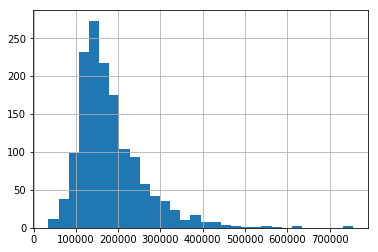

In [7]:
df_train["SalePrice"].hist(bins=30)

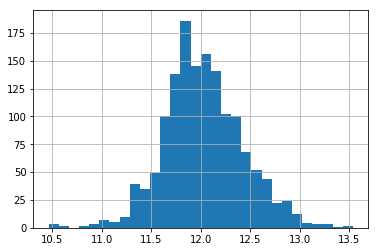

In [8]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#対数変換後の分布を確認
df_train["SalePrice"].hist(bins=30)

In [9]:
#カテゴリカルでない特徴量
non_categoricals = df_all.dtypes[df_all.dtypes != "object"].index
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.6].index
#歪度0.7より大きい特徴量を対数変換
df_all[skewed_feats] = np.log1p(df_all[skewed_feats])

In [10]:
#One Hot Encoding
df_all = pd.get_dummies(df_all)
#欠損値を平均値で補完
df_all = df_all.fillna(df_all.mean())

In [11]:
#学習データ、テストデータに分割
X = df_all[:df_train.shape[0]]
X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [23]:
# Import libraries

from sklearn.model_selection import GridSearchCV,learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.linear_model import LassoCV,ElasticNetCV,Lasso,ElasticNet
from sklearn.kernel_ridge import KernelRidge

from mlxtend.regressor import StackingRegressor
from xgboost import XGBRegressor

In [26]:
# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# #X_train = RobustScaler().fit_transform(X_train)
# X_train = pd.DataFrame(X_train, columns = df.columns )

# X_test = scaler.transform(X_test)
# X_test = pd.DataFrame(X_test, columns = df.columns)
# #X_test = RobustScaler().fit_transform(X_test)

In [33]:
kfold = KFold(n_splits=20, random_state= 0, shuffle = True)
def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kfold))
    return(rmse)

In [30]:
KR = KernelRidge()

KR_param_grid = {
    'alpha' : [0.93],
    'kernel' : ['polynomial'],
    'gamma':[0.001],
    'degree': [3],
    'coef0': [1.5]
}

KR_CV = GridSearchCV(KR, param_grid = KR_param_grid, cv = kfold, scoring = "neg_mean_squared_error",n_jobs = -1, verbose = 1)
KR_CV.fit(X_train, y_train)
KR_best = KR_CV.best_estimator_
print(KR_best)



Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KernelRidge(alpha=0.93, coef0=1.5, degree=3, gamma=0.001, kernel='polynomial',
      kernel_params=None)


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.2s finished


In [34]:
y_submission_1 = np.expm1(KR_best.predict(X_test))
score = rmsle_cv(KR_best)
print("Kernel Ridge mean score:", score.mean())
print("Kernel Ridge std:", score.std())

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in expm1
  """Entry point for launching an IPython kernel.


Kernel Ridge mean score: 0.11475850283805729
Kernel Ridge std: 0.016950972589074662


In [38]:
lasso = LassoCV(alphas = [0.003], random_state = 1, n_jobs = -1, verbose = 1)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Optimized Alpha:", alpha)

lasso = LassoCV(alphas = alpha * np.linspace(0.5,1.5,20), cv = kfold, random_state = 1, n_jobs = -1)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Final Alpha:", alpha)

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
...[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Optimized Alpha: 0.003
Final Alpha: 0.004026315789473684


In [40]:
y_submission_2 = np.expm1(lasso.predict(X_test))

In [42]:
elnet = ElasticNetCV(alphas = [0.01, 0.03, 0.05, 0.07] 
                ,l1_ratio = [0.1, 0.3]
                ,cv = kfold, random_state = 1, n_jobs = -1)
elnet.fit(X_train, y_train)
alpha = elnet.alpha_
ratio = elnet.l1_ratio_
print("Optimized Alpha:", alpha)
print("Optimized l1_ratio:", ratio)

elnet = ElasticNetCV(alphas = alpha * np.linspace(0.5,1.5,20), l1_ratio = ratio * np.linspace(0.9,1.3,6), 
                     cv = kfold, random_state = 1, n_jobs = -1)
elnet.fit(X_train, y_train)

alpha = elnet.alpha_
ratio = elnet.l1_ratio_

print("Final Alpha:", alpha)
print("Final l1_ratio:", ratio)

Optimized Alpha: 0.03
Optimized l1_ratio: 0.1
Final Alpha: 0.02605263157894737
Final l1_ratio: 0.13


In [43]:
y_submission_3 = np.expm1(elnet.predict(X_test))

In [45]:
XGB = XGBRegressor()

xg_param_grid = {
              'n_estimators' :[870],
              'learning_rate': [0.04],
              
              'max_depth': [3],
              'min_child_weight':[0.2],
              
              'gamma': [0],
                
              'subsample':[0.8],
              'colsample_bytree':[0.7]
    
              #'reg_alpha':[0.08,0.09,0.095,0.1,0.15,0.2],
              #'reg_lambda':[0,0.001,0.002]
              }
                
gsXGB = GridSearchCV(XGB,param_grid = xg_param_grid, cv=kfold, scoring="neg_mean_squared_error", n_jobs= -1, verbose = 1)
gsXGB.fit(X_train,y_train)
XGB_best = gsXGB.best_estimator_
print(gsXGB.best_params_)

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.4min finished


{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 0.2, 'n_estimators': 870, 'subsample': 0.8}


In [48]:
y_submission_6 = np.expm1(gsXGB.predict(X_test))

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165', 'f166', 'f167', 'f168', 'f169', 'f170', 'f171', 'f172', 'f173', 'f174', 'f175', 'f176', 'f177', 'f178', 'f179', 'f180', 'f181', 'f182', 'f183', 'f184', 'f185', 'f186', 'f187', 'f188', 'f189', 'f190', 'f191', 'f192', 'f193', 'f194', 'f195', 'f196', 'f197', 'f198', 'f199', 'f200', 'f201', 'f202', 'f203', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f210', 'f211', 'f212', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f219', 'f220', 'f221', 'f222', 'f223', 'f224', 'f225', 'f226', 'f227', 'f228', 'f229', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f250', 'f251', 'f252', 'f253', 'f254', 'f255', 'f256', 'f257', 'f258', 'f259', 'f260', 'f261', 'f262', 'f263', 'f264', 'f265', 'f266', 'f267', 'f268', 'f269', 'f270', 'f271', 'f272', 'f273', 'f274', 'f275', 'f276', 'f277', 'f278', 'f279', 'f280', 'f281', 'f282', 'f283'] ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalHousePorchSF', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'Alley_Pave', 'LotShape_IR1', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_AllPub', 'Utilities_NoSeWa', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Gtl', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blmngtn', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Artery', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE', 'HouseStyle_1.5Fin', 'HouseStyle_1.5Unf', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_2Story', 'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior1st_ImStucc', 'Exterior1st_MetalSd', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_VinylSd', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 'Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Fa', 'ExterQual_Gd', 'ExterQual_TA', 'ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA', 'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Ex', 'BsmtQual_Fa', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtCond_Fa', 'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtFinType1_ALQ', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ', 'BsmtFinType1_LwQ', 'BsmtFinType1_Rec', 'BsmtFinType1_Unf', 'BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec', 'BsmtFinType2_Unf', 'Heating_Floor', 'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Ex', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix', 'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 'Functional_Mod', 'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'GarageFinish_Fin', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageQual_Ex', 'GarageQual_Fa', 'GarageQual_Gd', 'GarageQual_Po', 'GarageQual_TA', 'GarageCond_Ex', 'GarageCond_Fa', 'GarageCond_Gd', 'GarageCond_Po', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P', 'PavedDrive_Y', 'PoolQC_Ex', 'PoolQC_Fa', 'PoolQC_Gd', 'Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_Gar2', 'MiscFeature_Othr', 'MiscFeature_Shed', 'MiscFeature_TenC', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal', 'SaleCondition_Partial']
expected f244, f17, f36, f59, f183, f82, f185, f264, f243, f75, f159, f68, f192, f122, f149, f95, f228, f118, f4, f33, f107, f256, f21, f155, f163, f278, f199, f72, f109, f101, f58, f94, f169, f42, f240, f96, f126, f255, f115, f168, f3, f57, f0, f35, f142, f15, f175, f106, f1, f29, f108, f230, f251, f131, f116, f219, f133, f128, f137, f194, f12, f79, f203, f23, f172, f156, f18, f127, f165, f191, f62, f91, f262, f268, f13, f146, f178, f134, f64, f2, f114, f124, f261, f8, f237, f54, f202, f253, f45, f198, f254, f130, f281, f6, f100, f180, f196, f276, f76, f26, f83, f151, f47, f53, f66, f73, f89, f99, f177, f245, f145, f160, f269, f16, f200, f225, f184, f176, f30, f39, f105, f136, f139, f266, f238, f63, f25, f143, f161, f84, f248, f224, f113, f38, f31, f56, f120, f221, f90, f138, f170, f49, f271, f283, f102, f258, f5, f67, f197, f282, f152, f77, f162, f236, f189, f65, f174, f20, f81, f259, f97, f80, f246, f277, f132, f51, f208, f147, f279, f213, f247, f187, f24, f37, f104, f60, f223, f125, f98, f112, f129, f144, f216, f141, f220, f10, f119, f19, f173, f215, f217, f117, f40, f135, f209, f167, f207, f231, f257, f234, f229, f193, f171, f69, f157, f218, f88, f188, f74, f123, f153, f164, f232, f210, f280, f92, f14, f182, f181, f27, f249, f275, f50, f87, f154, f241, f150, f70, f204, f179, f242, f222, f34, f28, f55, f121, f86, f111, f140, f205, f227, f252, f11, f235, f206, f274, f195, f233, f71, f201, f265, f93, f272, f273, f48, f110, f148, f214, f158, f41, f239, f85, f7, f22, f9, f52, f44, f46, f226, f186, f260, f212, f270, f263, f32, f211, f166, f267, f190, f43, f103, f61, f250, f78 in input data
training data did not have the following fields: FullBath, BsmtQual_Fa, OverallQual, Heating_Floor, Exterior2nd_Wd Shng, Exterior1st_ImStucc, FireplaceQu_TA, Condition1_RRAe, Neighborhood_Crawfor, Neighborhood_NAmes, Condition1_Norm, Condition1_RRNn, LowQualFinSF, Electrical_SBrkr, Condition1_Artery, GarageQual_Fa, RoofMatl_WdShngl, SaleCondition_Partial, LotConfig_CulDSac, KitchenAbvGr, ScreenPorch, RoofMatl_Tar&Grv, Exterior2nd_AsbShng, BsmtCond_Po, GarageType_2Types, OverallCond, SaleCondition_AdjLand, Exterior2nd_MetalSd, RoofStyle_Flat, BsmtFinType2_ALQ, GarageQual_Gd, GarageCond_Fa, Functional_Maj1, LandContour_Bnk, BsmtFinType2_BLQ, Functional_Maj2, HouseStyle_SFoyer, HouseStyle_2.5Unf, BsmtFinType1_BLQ, HeatingQC_Ex, Condition2_Norm, ExterQual_Ex, ExterCond_Gd, Functional_Typ, RoofMatl_WdShake, TotalBsmtSF, FireplaceQu_Ex, SaleType_ConLw, HouseStyle_2Story, Electrical_FuseF, HouseStyle_1.5Unf, ExterCond_TA, LandSlope_Gtl, BsmtExposure_No, MSSubClass, Exterior2nd_AsphShn, BsmtCond_Gd, MSZoning_RH, Street_Pave, LotShape_IR1, Heating_Grav, LandSlope_Sev, Heating_Wall, FireplaceQu_Gd, GarageQual_Ex, MiscFeature_TenC, Condition2_Artery, Exterior1st_HdBoard, MiscFeature_Othr, LotShape_IR3, Exterior2nd_VinylSd, Alley_Pave, MasVnrType_BrkFace, Condition2_Feedr, HouseStyle_1Story, KitchenQual_Gd, Neighborhood_BrDale, MasVnrArea, SaleCondition_Normal, ExterQual_Fa, Electrical_FuseP, Neighborhood_Timber, KitchenQual_Ex, LotConfig_Inside, Exterior2nd_Brk Cmn, PoolQC_Ex, Exterior1st_CBlock, BsmtFinType1_LwQ, PoolQC_Gd, LotShape_IR2, RoofStyle_Gambrel, BsmtFinType1_Unf, BldgType_2fmCon, BsmtFinType2_Unf, HouseStyle_SLvl, BsmtFinType1_ALQ, Neighborhood_SawyerW, BsmtQual_Ex, Functional_Min2, BsmtFinType2_LwQ, Functional_Mod, HalfBath, SaleType_CWD, GarageType_BuiltIn, SaleCondition_Alloca, Neighborhood_StoneBr, SaleType_Oth, Condition2_PosA, BsmtFullBath, HouseStyle_2.5Fin, Condition2_RRAe, Condition2_RRAn, Condition1_RRAn, RoofStyle_Mansard, Exterior1st_VinylSd, Neighborhood_IDOTRR, BsmtCond_Fa, GarageFinish_Unf, PoolArea, LotConfig_Corner, GarageType_CarPort, Neighborhood_NoRidge, MSZoning_RL, Neighborhood_Blueste, Exterior2nd_CBlock, SaleType_Con, Condition1_PosN, BsmtFinSF2, RoofMatl_Roll, GarageFinish_RFn, LandContour_Low, MasVnrType_None, Neighborhood_Mitchel, ExterQual_Gd, OpenPorchSF, BsmtExposure_Gd, SaleCondition_Family, Functional_Min1, BsmtFinType2_GLQ, Neighborhood_OldTown, BsmtFinType1_Rec, BldgType_Duplex, PavedDrive_N, Neighborhood_Gilbert, KitchenQual_TA, Neighborhood_NridgHt, Exterior2nd_CmentBd, SaleType_WD, Exterior1st_AsphShn, Fence_GdWo, Heating_GasW, Condition2_RRNn, 2ndFlrSF, Condition1_PosA, RoofStyle_Shed, WoodDeckSF, BsmtExposure_Mn, HeatingQC_Po, Exterior1st_Stone, Exterior1st_Plywood, HeatingQC_TA, BsmtHalfBath, PavedDrive_P, GarageFinish_Fin, ExterQual_TA, LandContour_HLS, Foundation_BrkTil, Exterior1st_BrkComm, RoofStyle_Gable, GarageQual_TA, Neighborhood_SWISU, LotArea, Exterior2nd_Stucco, LotFrontage, RoofMatl_CompShg, Foundation_Wood, Foundation_CBlock, CentralAir_Y, Heating_OthW, KitchenQual_Fa, MasVnrType_Stone, MiscFeature_Shed, MoSold, Exterior1st_Wd Sdng, GarageCond_Ex, Fence_MnWw, GarageCond_Gd, Electrical_FuseA, MSZoning_RM, Neighborhood_BrkSide, Neighborhood_Somerst, PavedDrive_Y, LotConfig_FR3, LandSlope_Mod, Neighborhood_ClearCr, EnclosedPorch, Exterior2nd_BrkFace, Exterior2nd_Wd Sdng, HeatingQC_Gd, YearBuilt, GarageType_Detchd, SaleType_ConLI, SaleType_New, Electrical_Mix, Street_Grvl, BldgType_Twnhs, LotShape_Reg, Exterior1st_AsbShng, BsmtFinType1_GLQ, SaleType_ConLD, Neighborhood_Veenker, BedroomAbvGr, BsmtQual_Gd, Foundation_Stone, BsmtFinSF1, BldgType_TwnhsE, Exterior1st_CemntBd, BsmtFinType2_Rec, Condition1_RRNe, Exterior1st_Stucco, Fireplaces, Neighborhood_Blmngtn, Exterior2nd_Other, Condition1_Feedr, BsmtQual_TA, MSZoning_FV, Neighborhood_CollgCr, Exterior2nd_Stone, Exterior1st_WdShing, Foundation_Slab, HeatingQC_Fa, Condition2_PosN, Fence_MnPrv, FireplaceQu_Po, RoofMatl_Membran, SaleType_COD, RoofMatl_Metal, Neighborhood_NPkVill, BsmtCond_TA, Neighborhood_MeadowV, CentralAir_N, LotConfig_FR2, SaleCondition_Abnorml, Neighborhood_NWAmes, Exterior1st_BrkFace, FireplaceQu_Fa, GarageType_Attchd, YearRemodAdd, YrSold, Exterior2nd_Plywood, Foundation_PConc, ExterCond_Po, Functional_Sev, GarageCond_TA, MSZoning_C (all), MiscVal, Alley_Grvl, ExterCond_Fa, TotalHousePorchSF, GrLivArea, LandContour_Lvl, Fence_GdPrv, Utilities_AllPub, Exterior2nd_ImStucc, BsmtExposure_Av, BldgType_1Fam, Neighborhood_Edwards, PoolQC_Fa, ExterCond_Ex, RoofStyle_Hip, BsmtUnfSF, HouseStyle_1.5Fin, Neighborhood_Sawyer, Exterior1st_MetalSd, GarageQual_Po, GarageCars, MasVnrType_BrkCmn, Utilities_NoSeWa, GarageType_Basment, GarageCond_Po, Heating_GasA, 3SsnPorch, MiscFeature_Gar2, Exterior2nd_HdBoard

In [56]:
from bayes_opt import BayesianOptimization

# df = preprocess(pd.read_csv('./train.csv'))
# train_x = df.drop('Survived', axis=1)
# train_y = df.Survived
xgtrain = xgb.DMatrix(X_train, label=y_train)

def xgboost_cv(
    learning_rate,
    max_depth,
    subsample,
    colsample_bytree,
    min_child_weight,
    gamma,
    alpha):
    
    params = {}
    params['learning_rate'] = learning_rate
    # maximum depth of a tree, increase this value will make the model more complex / likely to be overfitting.
    params['max_depth'] = int(max_depth) 
    #  subsample ratio of the training instance. Setting it to 0.5 means that XGBoost randomly collected half of the data instances to grow trees and this will prevent overfitting.
    params['subsample'] = subsample
    # subsample ratio of columns when constructing each tree.
    params['colsample_bytree'] = colsample_bytree 
    # minimum sum of instance weight (hessian) needed in a child. The larger, the more conservative the algorithm will be.
    params['min_child_weight'] = min_child_weight
    # minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
    params['gamma'] = gamma 
    # L1 regularization term on weights, increase this value will make model more conservative. 
    params['alpha'] = alpha 
    params['objective'] = 'binary:logistic'

    cv_result = xgb.cv(
        params,
        xgtrain,
        num_boost_round=10, 
        nfold=3,
        seed=0,
        # Validation error needs to decrease at least every <stopping_rounds> round(s) to continue training.
        # callbacks=[xgb.callback.early_stop(20)]
    )

    return 1.0 - cv_result['test-error-mean'].values[-1]


xgboost_cv_bo = BayesianOptimization(xgboost_cv, 
                             {
                                 'learning_rate': (0.1, 0.9),
                                 'max_depth': (5, 15),
                                 'subsample': (0.5, 1),
                                 'colsample_bytree': (0.1, 1),
                                 'min_child_weight': (1, 20),
                                 'gamma': (0, 10),
                                 'alpha': (0, 10),
                             })



In [13]:
y_pred = reg.predict(X_test)
print("ラッソ回帰でのRMSE:",np.sqrt(mean_squared_error(y_pred, y_test)))

ラッソ回帰でのRMSE: 0.11431077123835078


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 変換器・推定器オブジェクト作成
standardizer = StandardScaler()
pca = PCA()
reg = ElasticNet(random_state=42)
a = np.arange(0.003,0.004,100)
gscv = GridSearchCV(reg, param_grid={'alpha': a}, cv=2)

pl = Pipeline([
        ('standardize', standardizer),
        ('pca', pca),
        ('gs_elastic_net', gscv)
        ])

pl.fit(X_train, y_train)

# テストデータに対して予測
y_pred_ela = pl.predict(X_test)

# 評価
print("elastic回帰でのRMSE:",np.sqrt(mean_squared_error(y_pred_ela, y_test)))

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


elastic回帰でのRMSE: 0.12293114811498987


/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [15]:
lgb_train = lgb.Dataset(X_train,y_train)

In [16]:
params = {'task': 'train','boosting_type': 'gbdt','objective': 'regression','metric': {'l2'},'num_leaves': 256,
'learning_rate': 0.01,'num_iterations':2000,'feature_fraction': 0.4,'bagging_fraction': 0.7,'bagging_freq': 5}
gbm = lgb.train(params, lgb_train, num_boost_round=1500)
y_test_pred_lgb = gbm.predict(np.array(X_test), num_iteration=gbm.best_iteration)
#RMSE
print("LightGBMでのRMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LightGBMでのRMSE: 0.11716578498521343


In [17]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(max_depth=5, n_estimators=500, subsample=0.8)
xgb_reg.fit(X_train,y_train)
#RMSE
y_pred3 = xgb_reg.predict(X_test)
print("xgboostでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred3)))

xgboostでのRMSE: 0.12106263301859242


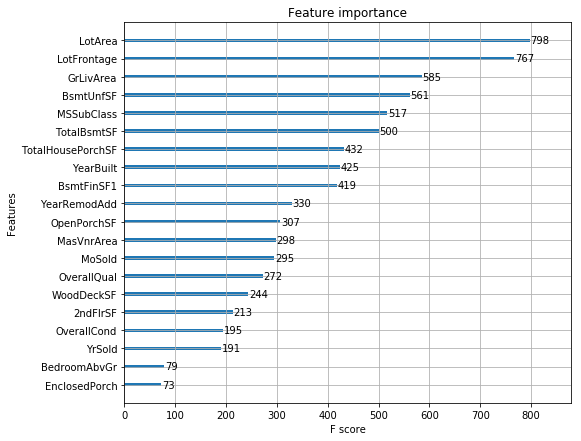

In [18]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(8,7))
plot_importance(xgb_reg, ax=ax, max_num_features=20)
plt.show()

In [19]:
print("LightGBM+Lassoのスタッキング時のRMSE:",np.sqrt(mean_squared_error(y_test, (y_pred*0.7+y_test_pred_lgb*0.3))))

LightGBM+Lassoのスタッキング時のRMSE: 0.11061062565043893


In [20]:
#全データで学習
reg.fit(X, y)
lgb_train_full = lgb.Dataset(X,y)
gbm = lgb.train(params, lgb_train_full, num_boost_round=1500)

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [21]:
#ラッソ・LightGBMの予測及びスタッキング
pred = np.expm1(reg.predict(X_for_test))
pred2 = np.expm1(gbm.predict(X_for_test))
pred3 = (pred*0.7+pred2*0.3)

In [22]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":pred3})
solution.to_csv("sample3.csv", index = False)